# The Best Neighborhood in Pittsburgh Presentation
**Simon Schueller (sps67)**  
**Eric Anderson (ema85)**  
**Justin Reagle (jmr278)**  

![DataGIF](https://media.giphy.com/media/HUplkVCPY7jTW/giphy.gif)

# Data Sets
* police_arrest_data
* playground_equipment
* housing_prices

# Metrics and Calculations

## Police arrest data
Analyzing [police_arrest_data](https://data.wprdc.org/dataset/arrest-data) from the WPRDC to determine the best neighborhood in Pittsburgh.

#### Abstract
There are unique codes to identify specific offenses that led to arrests. These offense types will be used to calculate a score for each neighborhood in Pittsburgh. Each offense listed for an arrest will automatically count for +1 but some specific offenses will count for more than +1. These scores for each arrest in a neighborhood will then be summed and normalized to a value between 0 and 1. The neighborhood with the lowest overall score is deemed most desireable to live. This neighborhood will be the place with a small amount of crimes, which are not **personal** or **property** crimes.

#### Special Offenses
Source: [Categories of Crimes](https://www.justia.com/criminal/offenses/)  

**Personal Crimes** and **Property Crimes** are treated as special cases and bear more weight on determining score, since they are to be avoided at all costs.  

"Personal crimes are those that result in physical or mental harm to another person." [Justia](https://www.justia.com/criminal/offenses/)   
"Property crimes typically involve interference with the property of another." [Justia](https://www.justia.com/criminal/offenses/)

* Retail Theft +2
* Aggravated Assault +4
* Recklessly Endangering Another Person +2
* Endangering Welfare of Children +3
* Simple Assault +3
* Intentionally Damages Real Or Personal Property Of Another +2
* Robbery +3
* Burglary +3
* Theft by Unlawful Taking or Disposition +2
* Harassment by Physical Contact, or Attempts or Threats +3
* Robbery of Motor Vehicle +3
* Criminal Homicide +10
* Kidnapping +7
* Reckless Driving +2
* Rape +5
* Sexual Assault +3
* Indecent Assault +3
* Aggravated Indecent Assault +3
* Involuntary Manslaughter +5
* Homicide by Vehicle +10
* Homicide by Vehicle While Driving Under the Influence +10
* Strangulation +5

#### Police arrests data

In [17]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

arrests = pd.read_csv("https://data.wprdc.org/datastore/dump/e03a89dd-134a-4ee8-a2bd-62c40aeebc6f")
# Import RegEx for Python
import re

# Arrays of codes based on special point values
plus_2 = [3929, 2705, 3304, 3921, 3736]
plus_3 = [4304, 2701, 3701, 3502, 2709, 3702, 3124, 3126]
plus_4 = [2702]
plus_5 = [3121, 2504, 2718]
plus_7 = [2901]
plus_10 = [2501, 3732, 3735]

# Function to calculate scores based on codes
def get_value(code):
    if code in plus_2:
        return 2
    elif code in plus_3:
        return 3
    elif code in plus_4:
        return 4
    elif code in plus_5:
        return 5
    elif code in plus_7:
        return 7
    elif code in plus_10:
        return 10
    else:
        return 1


scores = {}

# Get each row from arrests
for arrest in arrests.index:
    
    # Make sure a valid entry is made in each column
    if isinstance(arrests['INCIDENTNEIGHBORHOOD'][arrest], str) and isinstance(arrests["OFFENSES"][arrest], str):
        
        neighborhood = arrests['INCIDENTNEIGHBORHOOD'][arrest]
        offences_str = arrests["OFFENSES"][arrest]
        
        # Make array of individual offences
        offences = [offence.strip() for offence in offences_str.split('/')]
        for offence in offences:
            
            # Get offence code by regex
            offence_code = re.search(r'\d+', offence)
            if offence_code != None:
                offence_code = int(offence_code.group())
            
            # Get point value for that code
            points = get_value(offence_code)
            
            # Filter out bad input
            if neighborhood[:3] != "Mt." and "-Herrs" not in neighborhood:
                
                # Add to scores dictionary
                if neighborhood in scores:
                    scores[neighborhood] += points
                else:
                    scores[neighborhood] = points
                    
# Normalize the score
max_score = max(scores.values())
for score in scores:
    scores[score] /= max_score
    scores[score] = round(scores[score], 3)
                    
# Sort dictionary of scores                    
sorted_scores = sorted(scores.items(), key=lambda x: x[1])

# Print each key value pair in sorted_scores
for i in range(10):
    print(str(i + 1) + ". " + sorted_scores[i][0] + " - " + str(sorted_scores[i][1]))

1. Regent Square - 0.008
2. Central Northside - 0.008
3. Swisshelm Park - 0.01
4. Ridgemont - 0.011
5. Outside County - 0.012
6. New Homestead - 0.013
7. Chartiers City - 0.013
8. St. Clair - 0.014
9. East Carnegie - 0.017
10. Outside State - 0.021


# Results

### A TIE!!??

![football_gif](https://media.giphy.com/media/xT5LMEGl4kZXYX0tO0/giphy.gif)

There was a tie between **Regent Square** and **Central Northside** for best neighborhood by my metrics. I will give the win to **Regent Square** since it was named #1 neighborhood to live in pittsburgh in 2017. Overall, It should be noted that the higher scoring neighborhoods are generally of larger population size. My metric is most usefull when comparing neighborhoods of similar size, otherwise it starts to become simply a population map as pictured by the map graph below. But, if a low crime and low population neighborhood is desireable to you, then **Regent Square** is a place you can leave your door unlocked.

#### Visualization

<ipython-input-18-0020f4ef28f2>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  scores_map["center"] = scores_map["geometry"].centroid


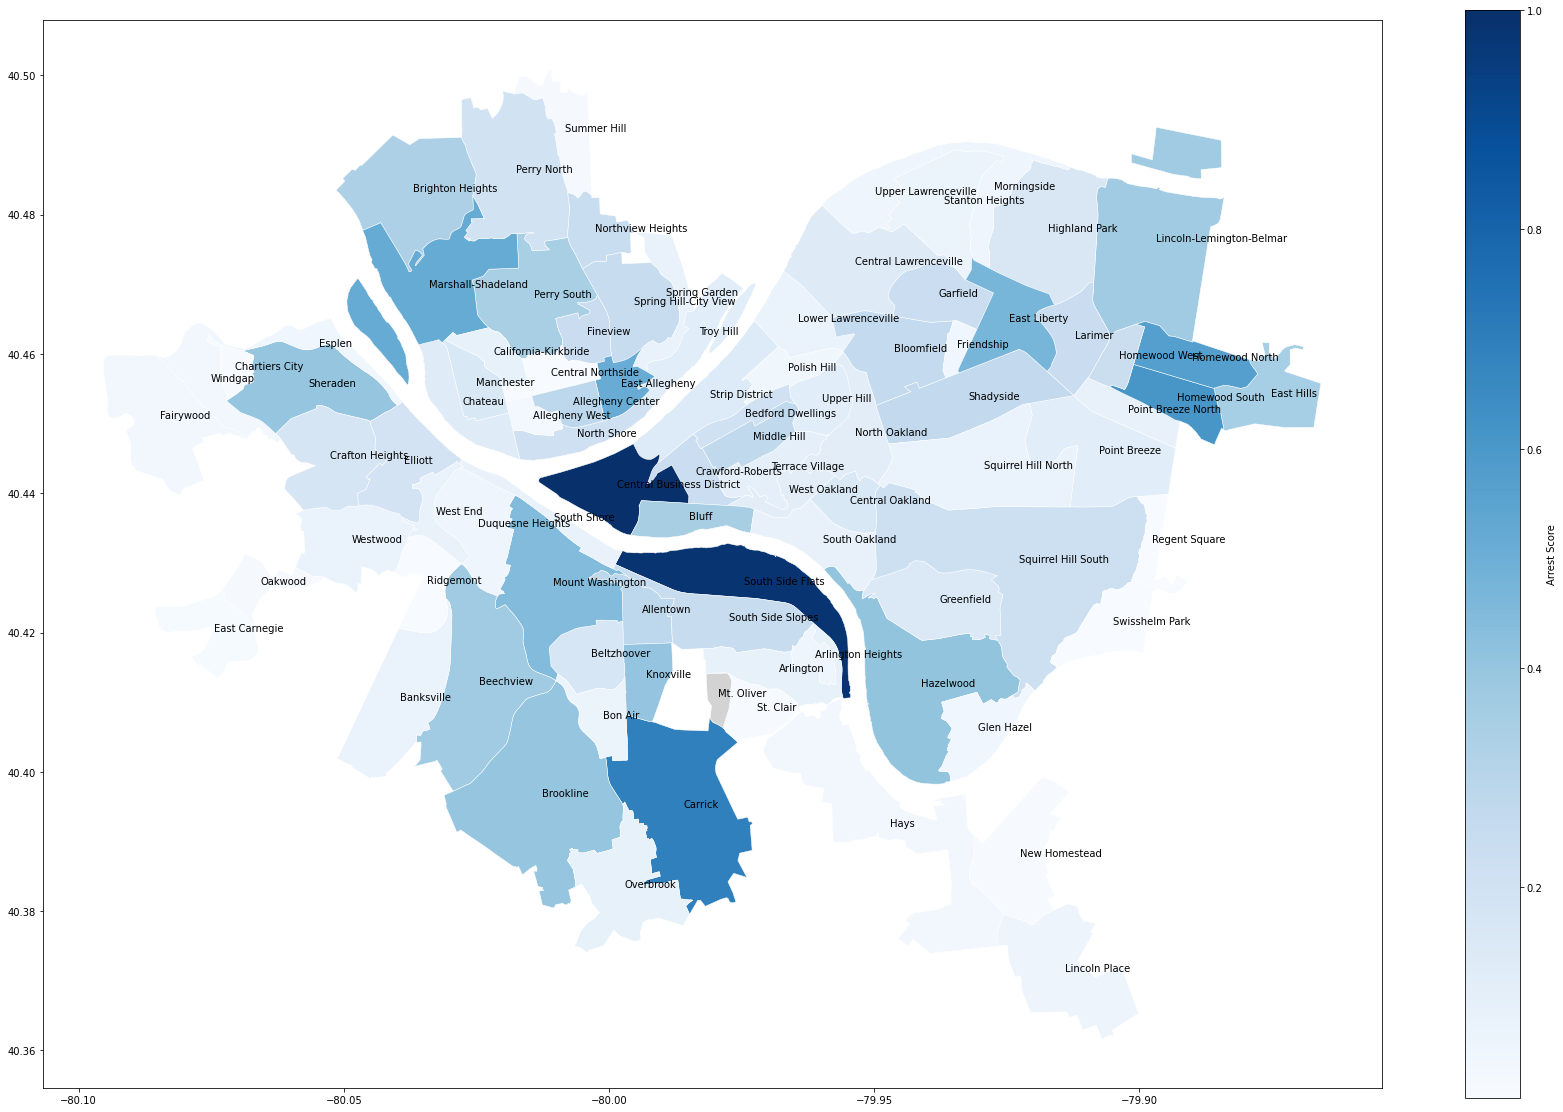

In [18]:
import geopandas

# Read in file with geographical data of Pittsburgh Neighborhoods
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") # read in the shapefile

# Create dataframe from scores
df_scores = pd.DataFrame.from_dict(sorted_scores)

# Merge with map dataframe
scores_map = neighborhoods.merge(df_scores, how='left', left_on='hood', right_on=0)

# Setup for labels on data regions
scores_map["center"] = scores_map["geometry"].centroid
scores_map_points = scores_map.copy()
scores_map_points.set_geometry("center", inplace = True)

ax = scores_map.plot(column=1,
                     cmap='Blues',
                     legend=True,
                     legend_kwds={'label': "Arrest Score"},
                     figsize = (30, 20),
                     missing_kwds={"color": "lightgrey"}, 
                     edgecolor = "white",
                     linewidth = 0.5)
texts = []

# Create the labels
for x, y, label in zip(scores_map_points.geometry.x, scores_map_points.geometry.y, scores_map_points["hood"]):
    texts.append(plt.text(x, y, label, fontsize = 10))

## Playground Data

### Abstract
For my portion of the analysis, I wanted to see which Pittsburgh neighborhood had the best playgrounds. This metric is especilaly important for families with children, and it can be representative of how kid-friendly a neighborhood is. I found [this dataset](https://data.wprdc.org/dataset/playground-equipment) which lists every piece of playground equipment in Pittsburgh, and I analyzed it using a few different standards. I needed to give each neighborhood a score between 0 and 1 for easy combination using our chosen method of data collection.
#### How to calculate a score?
The easiest way to get a score between 0 and 1 for each neighborhood was to use a point system to give each neighborhood a score, and then map my resulting scores to be between 0 and 1 (by dividing each score by the maximum). When giving neighborhoods points, I wanted to not only reward neighborhoods for having a large number of playgrounds (which would favor large neighborhoods), but also reward neighborhoods for having high-quality neighborhoods. Thus, I came up with 4 different metrics that would combine for the final score:
+ Number of pieces of equipment
+ Number of playgrounds
+ Number of ADA accessible pieces of equipment
+ Number of unique pieces of equipment in a nieghborhood

Rather than simply add up all these values, I wanted to add weighting that could emphasize certain areas of others. The most important things to weight in my opinion were the number of playgrounds (which is small compared to the other numbers), the number of ADA accessible pieces (once again a small number), and the quality metrics (which was combined number of ADA accessible pieces and unique pieces). I added variables to control weighting and adjusted them until I thought they were fair.

### Playground Data

In [19]:
#Playground Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

playground_equipment = pd.read_csv("playground_data.csv")
playground_equipment.head()

grouped_equipment = playground_equipment.groupby('neighborhood')

# creating the dictionary with every neighborhood in the dataset and assigning it a score of 0 to start
playground_scores = dict()
for neighborhood in playground_equipment.neighborhood.unique():
    playground_scores[neighborhood] = 0

# setting up the constants
num_playgrounds_weight = 2  
ada_accessible_weight = 4
quality_weight = 10

# adding the score for number of unique equipment pieces (quality)
for i in range(grouped_equipment.equipment_type.nunique().count()):
    playground_scores[grouped_equipment.equipment_type.nunique().index[i]] += grouped_equipment.equipment_type.nunique()[i]

# adding the score for the number of ADA accessible equipment pieces
for i in range(grouped_equipment.ada_accessible.value_counts().count()):
    if grouped_equipment.ada_accessible.value_counts().index[i][1] == "t":
        playground_scores[grouped_equipment.ada_accessible.value_counts().index[i][0]] += grouped_equipment.ada_accessible.value_counts()[i] * ada_accessible_weight

# weight the quality score
for neighborhood in playground_scores:
    playground_scores[neighborhood] *= quality_weight
        
# adding the score for number of pieces of equipment (quantity)
for i in range(grouped_equipment.id.count().count()):
    playground_scores[grouped_equipment.id.count().index[i]] += grouped_equipment.id.count()[i]

# adding the score for number of playgrounds (quantity)
for i in range(grouped_equipment.name.nunique().count()):
    playground_scores[grouped_equipment.name.nunique().index[i]] += grouped_equipment.name.nunique()[i] * num_playgrounds_weight

# normalizing the score to a (0, 1) range
max_score = max(playground_scores.values())
for neighborhood in playground_scores:
    playground_scores[neighborhood] /= max_score

#### Visualization

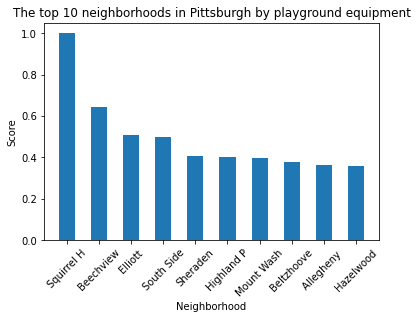

In [20]:
sorted_scores = sorted(playground_scores.items(), key=lambda x: x[1], reverse=True)
data = []
labels = []
for i in range(10):
    labels.append(sorted_scores[i][0][0:10])
    data.append(sorted_scores[i][1])

plt.bar(labels, data, width=0.5)
plt.title("The top 10 neighborhoods in Pittsburgh by playground equipment")
plt.xlabel("Neighborhood")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

#### Results - Playground Data
Squirrel Hill South has a commanding lead in my final results. This isn't a huge surprise as Squirrel Hill is fairly large and contains Schenley Park, which of course has a lot of playground equipment scattered throughout. It is important to note that the data set I used counted a type of equipment called "play area" which is presumably any open area designated for children to play. This means that some of the "equipment" that is counted for a neighborhood might not even be apparent at first glance. I tweaked the weightings some in order to try to close the gap between Squirel Hill and the other neighborhoods, but it appears as though Squirrel Hill has so many playgrounds that the weighting doesn't really matter. It really is best-in-class overall in terms of playgrounds.

## Housing Cost Data

#### Abstract
Homes that are around the price range of $100,000 - $300,000 are going to be considered more heavily because of how they fall within the average price of a home in Pennsylvania, according to [Zillow](https://www.zillow.com/pa/home-values/). With that in mind the top 10 should be the neighborhoods with the most homes in this price range.


#### Housing Cost Data

In [21]:
house_data = pd.read_csv("https://data.wprdc.org/dataset/5b18c198-474c-4723-b735-cc5220ad43cc/resource/13982f58-e618-400c-8f69-6a32dbd7c68f/download/value.csv")

total = []
neighborhood = [] # added 
for y in range(0, len(house_data.index)):
    add = 0
    for x in house_data.iloc[y, [30,32,34,36,38,40]]:
        add = add + x
    total.append(add)
    neighborhood.append(house_data.iloc[y, 0]) # add titles

temp_dict = {"Neighborhoods": neighborhood, "Total": total} # dictionary with titles
houses = pd.DataFrame(temp_dict) # pass in dict

# for x in range(0, len(total)):
#     houses.rename(index = {x: data.iloc[x, [0]]})

percentage = []
for x in range(0, len(total)):
    if house_data.iloc[x,2] == 0:
        math = 0;  #For the neighboorhoods that had 0 houses in survey
    else:
        math = total[x]/ house_data.iloc[x, 2]
    percentage.append(math)
    
house_per = pd.DataFrame(percentage)
house_data.head()

,Neighborhood,Id,Estimate; Total:,Margin of Error; Total:,"Estimate; Total: - Less than $10,000","Margin of Error; Total: - Less than $10,000","Estimate; Total: - $10,000 to $14,999","Margin of Error; Total: - $10,000 to $14,999","Estimate; Total: - $15,000 to $19,999","Margin of Error; Total: - $15,000 to $19,999",...,"Estimate; Total: - $500,000 to $749,999","Margin of Error; Total: - $500,000 to $749,999","Estimate; Total: - $750,000 to $999,999","Margin of Error; Total: - $750,000 to $999,999","Estimate; Total: - $1,000,000 to $1,499,999","Margin of Error; Total: - $1,000,000 to $1,499,999","Estimate; Total: - $1,500,000 to $1,999,999","Margin of Error; Total: - $1,500,000 to $1,999,999","Estimate; Total: - $2,000,000 or more","Margin of Error; Total: - $2,000,000 or more"
0,Allegheny Center,1,72.0,28.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000,...,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000
1,Allegheny West,2,69.0,31.000000,4.0,7.000000,0.0,10.000000,0.0,10.000000,...,0.0,10.000000,0.0,10.000000,11.0,17.000000,0.0,10.000000,0.0,10.000000
2,Allentown,3,538.0,112.769677,45.0,33.734256,19.0,21.118712,22.0,26.153394,...,6.0,16.763055,0.0,17.320508,0.0,17.320508,0.0,17.320508,0.0,17.320508
3,Arlington,4,492.0,84.433406,12.0,16.186414,29.0,27.513633,5.0,16.248077,...,7.0,17.916473,0.0,17.320508,3.0,15.779734,0.0,17.320508,0.0,17.320508
4,Arlington Heights,5,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000,...,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000


#### Visualization

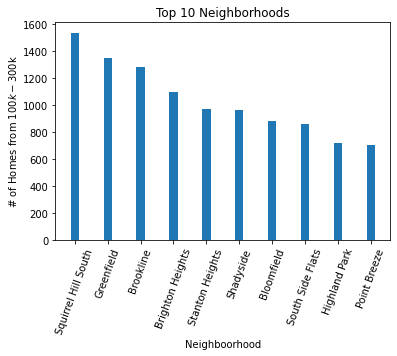

In [22]:
#Sort the houses in our price range from most to least per neighborhood
houses_sorted = houses.sort_values('Total', axis = 0, ascending = False, inplace = False, kind = 'quicksort')
top10NOvr = []
top10POvr = []
for x in range(0, 10):
    top10NOvr.append(houses_sorted.iloc[x, 0])
    top10POvr.append(houses_sorted.iloc[x, 1])
    
#Produce bar graph of homes
plt.bar(top10NOvr, top10POvr, width = 0.25)
plt.title("Top 10 Neighborhoods")
plt.xlabel("Neighboorhood")
plt.ylabel("# of Homes from $100k-$300k")
plt.xticks(rotation = 70)
plt.show()

### Results
As the bar graph shows, Squirrel Hill South has the most homes in the range of 100,000-300,000 dollars by a fair margin of about 150 more than the second place neighborhood of Greenfield. This gives Squirrel Hill South a large bump in the ranks of 'best' neighborhood, however will it be enough to make it the best neighborhood in Pittsburgh?

# Combining the Data

In [23]:
final_scores = dict()

playground_weighting = 1
arrest_weighting = 1
house_weighting = 1

#adding scores for playgrounds
for neighborhood in playground_scores:
    final_scores[neighborhood] = playground_scores[neighborhood] * playground_weighting

#adding scores for arrests
for neighborhood in scores:
    if neighborhood in final_scores:
        final_scores[neighborhood] = final_scores[neighborhood] + (1 - scores[neighborhood]) * arrest_weighting
    else:
        final_scores[neighborhood] = (1 - scores[neighborhood]) * arrest_weighting
        
#adding scores for house prices
for i in range(len(house_data.index)):
    neighborhood = house_data.iloc[i, 0]
    if neighborhood in final_scores:
        final_scores[neighborhood] = final_scores[neighborhood] + house_per.iloc[i, 0] * house_weighting
    else:
        final_scores[neighborhood] = house_per.iloc[i, 0] * house_weighting
        
#sorting total
final_sorted = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
for i in range(10):
    print(str(i + 1) + ". " + final_sorted[i][0] + " - " + str(final_sorted[i][1]))

1. Squirrel Hill South - 2.2676269035532997
2. Allegheny Center - 2.0783846153846155
3. Swisshelm Park - 1.9055941334929662
4. Friendship - 1.867392405063291
5. Regent Square - 1.8297625775584958
6. Greenfield - 1.829636760700889
7. New Homestead - 1.7909345711759503
8. Morningside - 1.7760519271085307
9. Banksville - 1.7638606013276066
10. Point Breeze North - 1.748875457875458


# Visualization

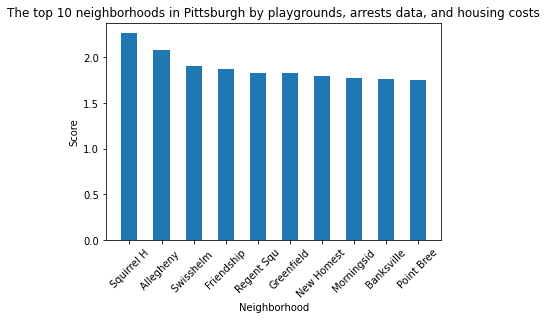

In [24]:
# Data Plot of top 10 Scoring neighborhoods
arr_scores = []
neighborhoods = []
for i in range(10):
    neighborhoods.append(final_sorted[i][0][0:10])
    arr_scores.append(final_sorted[i][1])

plt.bar(neighborhoods, arr_scores, width=0.5)
plt.title("The top 10 neighborhoods in Pittsburgh by playgrounds, arrests data, and housing costs")
plt.xlabel("Neighborhood")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

In [26]:
# Read in file with geographical data of Pittsburgh Neighborhoods
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") # read in the shapefile

# Create dataframe from scores
df_scores = pd.DataFrame(final_sorted)

# Merge with map dataframe
scores_map = neighborhoods.merge(df_scores, how='left', left_on='hood', right_on=0)

# Setup for labels on data regions
scores_map["center"] = scores_map["geometry"].centroid
scores_map_points = scores_map.copy()
scores_map_points.set_geometry("center", inplace = True)

ax = scores_map.plot(column=1,
                     cmap='coolwarm',
                     legend=True,
                     legend_kwds={'label': "Overall Score"},
                     figsize = (30, 20),
                     missing_kwds={"color": "lightgrey"}, 
                     edgecolor = "white",
                     linewidth = 0.5)
texts = []

# Create the labels
for x, y, label in zip(scores_map_points.geometry.x, scores_map_points.geometry.y, scores_map_points["hood"]):
    texts.append(plt.text(x, y, label, fontsize = 10))

<ipython-input-26-9cad4543f77c>:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  scores_map["center"] = scores_map["geometry"].centroid
/opt/tljh/user/lib/python3.8/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

# Conclusions

## Simon
    Determening which neighborhood in Pittsburgh is to be considered, "the best" is a very subjective question. We gave equal weight to low numbers of arrests, high numbers of playgrounds, and optimal housing costs. These are subjective metrics, but the data used in support of each metric is not. I can say difinitively which neighborhood in Pittsburgh has the lowest number of arrests based on the data I analyzed. However, the jump from lowest number of arrests, to best neighborhood in Pittsburgh is a reach. Nevertheless, here are my conclusions from the datasets analyzed, and their combination.

    For the most part, the areas with the highest population and closest proximity to downtown were the areas with the most arrests. The Homewood neighborhoods were an exception to this, since they were on the smaller side, far away from downtown, and still had a high amount of arrests. Squirrel Hill South was not one of the top ten scores, but still recieved a very good score by police arrest data metrics. Next, playground data obviously favored those neighborhoods with the highest concentration of parks. This is confirmed by the fact that Squirrel Hill South recieved a much higher score than all the other neighborhoods. Squirrel Hill south contains Schenley Park, which is very large and contains multiple playgrounds. Lastly, the housing data also ranked Squirrel Hill South with the best score for number of houses between $100,000 and $300,000.   

    So, by our definitive data analysis, and subjective metrics, Squirrel Hill South scored highest by the combination of our metrics. Squirrel Hill South has a low amount of arrests (not even top ten lowest though), the most playground equipment, and the most number of houses between our predetermined "ideal" price range. Tweaking the weights each metric recieves when combining them, will produce different results. However, if low arrests, lots of playground equipment, and affordable residential communities sounds good to you, then Squirrel Hill south is your "best neighborhood" too. 
 
## Eric
    After combining the housing cost, playground equipment, and arrest data, we found that Squirrel Hill South won. The most interesting thing to me is that Squirrel Hill placed first in playground equipment and housing costs, but didn't even break top 10 on the arrest data. That just goes to show that depending on what metric you use to define the "best" neighborhood, you will get widly different results. We ended up weighting each metric evenly for the final calculation. In reality, some metrics would be more important to different people and they could edit the weighting within our code in order to get a result tailored to them.
    
    I believe that the biggest factor that affected our result was playground data because of the huge lead that Squirrel Hill South had within that category. I played with the weighting for our final results a bit and found that arrests had to be weighted 3 times as much as playground data in order for Squirrel Hill to be usurped (it then moves to second place after Swisshelm Park). A big factor in this is that no other neighborhood was super strong in all 3 or even just 2 of the categories. No neighborhood appears in the top ten list for each metric. Highland Park appears in the top ten of two of the metrics, but didn't even make it to the final top 10.
    
    Squirrel Hill South is deserving of the title of best neighborhood in Pittsburgh according to our findings. Scoring first in playgrounds and housing cost makes it hard to beat, even if you want to adjust the weighting of the metrics. Even though it wasn't top 10 in lowest arrests, it still placed highly in that category as well. I think our data shows that Squirrel hill would be the perfect place for a family to move - it's a safe place with low arrests, kid-friendly with many playgrounds, and housing there is affordable.

## Justin
    After looking at all of the data, individually and combined, we found that Squirrel Hill South was our best neighborhood. This wasn't much of a suprise as Squirrel Hill South had the number 1 spot in 2 out of 3 metrics, but it was interseting to see that it did not break the top 10 in the arrests metric. Of course, these metrics may no be considered to be the most important by other people, but we collectivley believed these three should be seriously considered when deciding the best neighborhood.
       
       Overall, Squirell Hill South prevailed not becuase it completley out did the other neighborhoods in Pittsburgh, but becuase it managed to do fairly well in each category, while other neighborhoods may have only had 

# Overall Best Neighborhood is...

![DrumRollGIF](https://media.giphy.com/media/FP56vNcwOVyvu/giphy.gif)

### Squirrel Hill South 🎉 🎊 🎈 